### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [3]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, 1024)]

In [4]:
data = pd.read_csv('data/sacharose_1000/all.csv', sep = '\t').iloc[:,:-1]

In [5]:
data.columns = names

In [6]:
def load_spectrum(data, moment_of_time):
    ppm = data['ppm']
    intensity = data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    return sp

### Components

In [7]:
sacharose = pd.read_csv('data/sacharose_1000/sucrose.csv', sep = '\t', header=None).iloc[:,:-1]
glucose = pd.read_csv('data/sacharose_1000/glucose.csv', sep = '\t', header=None).iloc[:,:-1]
fructose = pd.read_csv('data/sacharose_1000/fructose.csv', sep = '\t', header=None).iloc[:,:-1]

all_substances = [sacharose, glucose, fructose]

In [8]:
spectra = []
for sub in all_substances:
    ppm = sub[0]
    ints = sub[1]
    sp = NMRSpectrum(confs = list(zip(ppm, ints)))
    sp.trim_negative_intensities()
    sp.normalize()
    spectra.append(sp)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


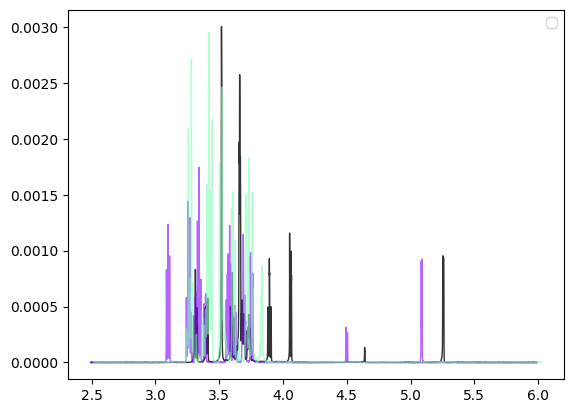

In [9]:
NMRSpectrum.plot_all(spectra, profile=True)

### Estimation

In [10]:
kappa = 0.1
kappa_th = 0.75

In [ ]:
proportions_in_times = []
noise_proportions_in_times = []

sp1 = load_spectrum(data, 1)
sp1.trim_negative_intensities()
sp1.normalize()

for i in range(1, 1024):
    print('This is timepoint '+str(i)+'.\n')
    mix = load_spectrum(data, i)
    estimation = estimate_proportions(mix, spectra, what_to_compare='area', 
                                      solver=pulp.GUROBI(msg=False),
                                     MTD=kappa, MTD_th=kappa_th)
        
    proportions_in_times.append(estimation['proportions'])
    noise_proportions_in_times.append(estimation['proportion_of_noise_in_components'])
    
    print('Proportions:\n')
    print(estimation['proportions'])
    print('\n')
    print('Proportion_of_noise_in_components:\n')
    print(estimation['proportion_of_noise_in_components'])
    print('\n')

This is timepoint 1.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Proportions:

[0.5065895569078493, 0.11880477958795978, 0.24557138059505387]


Proportion_of_noise_in_components:

0.0


This is timepoint 2.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5042802931923653, 0.10768348780144625, 0.2627835233799258]


Proportion_of_noise_in_components:

0.0


This is timepoint 3.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5093401516855401, 0.12562649400785092, 0.23197502563617012]


Proportion_of_noise_in_components:

0.0


This is timepoint 4.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5113494580485757, 0.1261470023324258

In [12]:
len(proportions_in_times)

1023

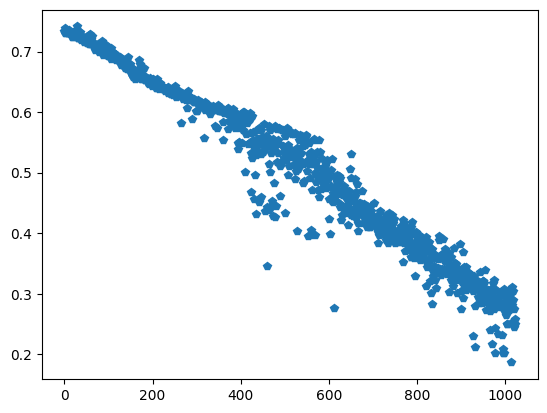

In [13]:
plt.plot(range(len(proportions_in_times)), [prop[0] for prop in proportions_in_times], 'p')

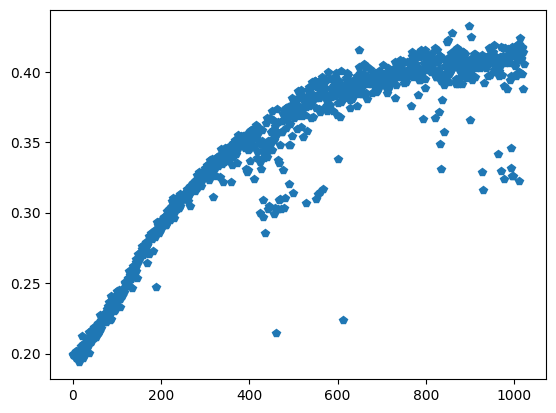

In [14]:
plt.plot(range(len(proportions_in_times)), [prop[1] for prop in proportions_in_times], 'p')

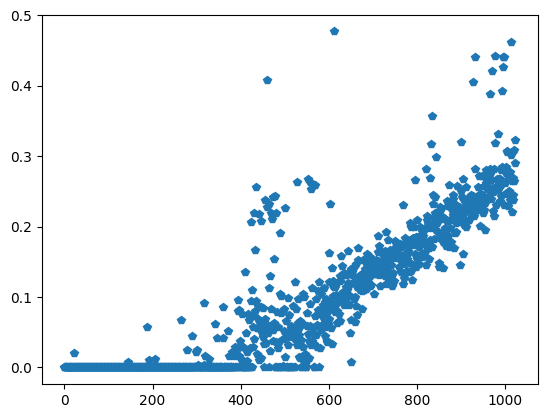

In [15]:
plt.plot(range(len(proportions_in_times)), [prop[2] for prop in proportions_in_times], 'p')

In [16]:
with open('results/sacharose_1000/comparing_with_first/known_substrats/proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(proportions_in_times, f)

In [17]:
with open('results/sacharose_1000/comparing_with_first/known_substrats/noise_proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_proportions_in_times, f)

### Linear regression

In [18]:
with open(r'results/sacharose_1000/comparing_with_first/known_substrats/proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y).reshape(-1,1)

In [19]:
t = np.array(range(1,1024))
t_and_ones = np.vstack([t, np.ones(len(t))]).T

In [22]:
slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]

/tmp/ipykernel_3869/1288480160.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]


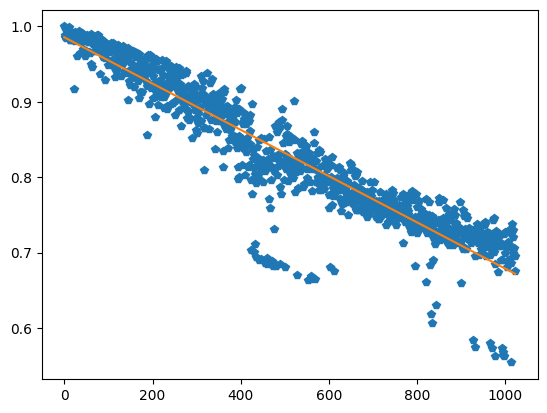

In [23]:
plt.plot(range(len(y)), [prop[0] for prop in y], 'p')
plt.plot(slope*t+intercept)